# Lower Limb dynamics
**Charles Pontonnier**

This short code is here to compute the joint torques related to the gait motion. An additional file (ID.py) is here to provide simple functions useful in this context.


## Markerset
![alt text](markerset.png "jeu de marqueurs utilisé")

## Notebook setup

In [2]:
import ezc3d 
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import ID #import des fonctions spécifiques au notebook

## Opening the C3D file, get the data

<font color='green'>**Question 1: The file is opened differently. Why ?**</font>

In [3]:
#Opening the file

c = ezc3d.c3d('DATA/walk.c3d', extract_forceplat_data=True);

point_data = c['data']['points'] #markers trajectories
point_labels=c['parameters']['POINT']['LABELS']# markers labels
point_rate=c['parameters']['POINT']['RATE'] # mocap framerate
analog_data = c['data']['analogs'] # analog data
analog_labels=c['parameters']['ANALOG']['LABELS'] # analog data labels
analog_rate=c['parameters']['ANALOG']['RATE'] # analogs framerate
f_mocap=point_rate['value'][0]
print('mocap frequency:', point_rate['value'][0],'Hz')
print('analogs frequency:', analog_rate['value'][0],'Hz')
# number of frames and samples
nf_mocap=len(point_data[0][0][:])
n_markers=len(point_data[0][:])
n_dims=len(point_data[:])
nf_analog=len(analog_data[0][:][:])
#analog and mocap times
t_point=np.linspace(0., nf_mocap/point_rate['value'][0], num=nf_mocap)
t_analog=np.linspace(0., nf_analog/analog_rate['value'][0], num=nf_analog)

print('Markers names',point_labels)
print('Number of markers',n_markers)
print('Dimensions',n_dims)
print('Number of frames',nf_mocap)
fc=6 #Hz low pass filter cutting frequency

g=9.81 #gravity






mocap frequency: 300.0 Hz
analogs frequency: 1500.0 Hz
Markers names {'type': -1, 'description': 'Trajectory labels', 'is_locked': False, 'value': ['LKNE', 'OXSENS', 'LTOE', 'LTAR', 'LTARI', 'LHEE', 'LANI', 'LANE', 'LKNI', 'LINF', 'LFWT', 'LBWT', 'RTOE', 'RTAR', 'RTARI', 'RHEE', 'RANI', 'RANE', 'RKNI', 'RKNE', 'RINF', 'RFWT', 'RBWT']}
Number of markers 23
Dimensions 4
Number of frames 1863


## Model parameters

In [4]:

#################################################
########### GEOMETRICAL PARAMETERS #############
#################################################

pOt=np.transpose([-74,-46,74])/1000#hip coordinates in the pelvis coordinate system

tGt=np.transpose([0,-190,0])/1000 #thigh CoM in the thigh coordinate system
sGs=np.transpose([0,-186,0])/1000 #shank CoM in the shank coordinate system
fGf=np.transpose([-30,-80,0])/1000 #foot CoM in the foot coordinate system

##############################################
########### INERTIAL PARAMETERS #############
##############################################

#thigh
mt=8.25 #kg
It=0.1434 #kg.m²
#shank
ms=3.21 #kg
Is=0.0463 #kg.m²
#foot
mf=0.8 #kg
If=0.0056 #kg.m²


## Joint centers

<font color='green'>**Question 2: A new step has been added to this processing. For what purpose ? Change the cutting frequency of the low pass filter to assess its impact on the data.**</font>

In [5]:
# Op (pelvis joint center) is approximated from the 4 pelvis markers
Op=np.zeros((3,nf_mocap))
Op[0,:]=ID.LP_filter(0.25*(point_data[0][10][:]+point_data[0][11][:]+point_data[0][21][:]+point_data[0][22][:])/1000,fc,f_mocap)
Op[1,:]=ID.LP_filter(0.25*(point_data[1][10][:]+point_data[1][11][:]+point_data[1][21][:]+point_data[1][22][:])/1000,fc,f_mocap)
Op[2,:]=ID.LP_filter(0.25*(point_data[2][10][:]+point_data[2][11][:]+point_data[2][21][:]+point_data[2][22][:])/1000,fc,f_mocap)

# Oh (hip joint center) is specifically computed thereafter

# Os (knee joint center) is computed from the knee markers
Os=np.zeros((3,nf_mocap))
Os[0,:]=ID.LP_filter(0.5*(point_data[0][18][:]+point_data[0][19][:])/1000,fc,f_mocap)
Os[1,:]=ID.LP_filter(0.5*(point_data[1][18][:]+point_data[1][19][:])/1000,fc,f_mocap)
Os[2,:]=ID.LP_filter(0.5*(point_data[2][18][:]+point_data[2][19][:])/1000,fc,f_mocap)

# Of (ankle joint center) is computed from the ankle markers

Of=np.zeros((3,nf_mocap))
Of[0,:]=ID.LP_filter(0.5*(point_data[0][16][:]+point_data[0][17][:])/1000,fc,f_mocap)
Of[1,:]=ID.LP_filter(0.5*(point_data[1][16][:]+point_data[1][17][:])/1000,fc,f_mocap)
Of[2,:]=ID.LP_filter(0.5*(point_data[2][16][:]+point_data[2][17][:])/1000,fc,f_mocap)


# Otoe (the foot extremety) is approximated from the toe marker
Otoe=np.zeros((3,nf_mocap))
Otoe[0,:]=ID.LP_filter(point_data[0][12][:]/1000,fc,f_mocap)
Otoe[1,:]=ID.LP_filter(point_data[1][12][:]/1000,fc,f_mocap)
Otoe[2,:]=ID.LP_filter(point_data[2][12][:]/1000,fc,f_mocap)


## Inverse Kinematics

This code is similar to the one available in Lower_Limbs_IK.ipynb

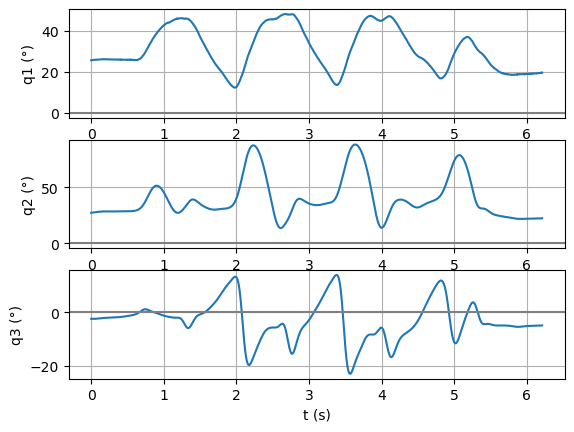

In [6]:
markers=np.zeros((n_markers,n_dims-1)) #temporary markers positions (more convenient to manipulate the data)
Ot=np.zeros((3,nf_mocap)) # position of the hip in the world coordinate system (empty for now)

# y vectors of all segments
yp=np.zeros((3,nf_mocap)) #y axis pelvis
yt=np.zeros((3,nf_mocap)) #y axis thigh
ys=np.zeros((3,nf_mocap)) #y axis shank
yf=np.zeros((3,nf_mocap)) #y axis foot

# joint angles
q1=np.zeros((nf_mocap)) # q1 hip flexion/extension
q2=np.zeros((nf_mocap)) # q2 knee flexion/extension
q3=np.zeros((nf_mocap)) # q3 ankle flexion/extension

for f in range(0,nf_mocap):

    for i in range(0,n_markers): # yp --> computing Rp0 at each frame et on isolating the second column (yp in R0)
        markers[i,0]=point_data[0][i][f]
        markers[i,1]=point_data[1][i][f]
        markers[i,2]=point_data[2][i][f]
    Rp0=ID.Rp(markers) 
    yp[:,f]=np.transpose([Rp0[0,1],Rp0[1,1],Rp0[2,1]])
    Ot[:,f]=Rp0@pOt+Op[:,f] #hip position in the world coordinate system at frame f
    yt[:,f]=(Ot[:,f]-Os[:,f])/np.linalg.norm(Ot[:,f]-Os[:,f])# yt --> vector Ot-Os and normalization
    ys[:,f]=(Os[:,f]-Of[:,f])/np.linalg.norm(Os[:,f]-Of[:,f])# ys --> vector Os-Of and normalization
    yf[:,f]=(Of[:,f]-Otoe[:,f])/np.linalg.norm(Of[:,f]-Otoe[:,f])# yf --> vector Of-Otoe and normalization
    q1[f]=np.arccos(np.transpose(yt[:,f])@yp[:,f])
    q2[f]=np.arccos(np.transpose(ys[:,f])@yt[:,f])
    q3[f]=np.arccos(np.transpose(yf[:,f])@ys[:,f])-np.pi/2 #be careful of the pi/2 change (anatomical position)
    
    
#plot of the 3 angles
plt.subplot(3,1,1)
plt.grid()
plt.plot(t_point,q1*180/np.pi)
plt.axhline(y=0,color='gray')
plt.xlabel('t (s)')
plt.ylabel('q1 (°)')


plt.subplot(3,1,2)
plt.grid()
plt.plot(t_point,q2*180/np.pi)
plt.axhline(y=0,color='gray')
plt.xlabel('t (s)')
plt.ylabel('q2 (°)')

plt.subplot(3,1,3)
plt.grid()
plt.plot(t_point,q3*180/np.pi)
plt.axhline(y=0,color='gray')
plt.xlabel('t (s)')
plt.ylabel('q3 (°)')

plt.show()


## CoM positions, velocities and accelerations

<font color='green'>**Question 3: Compute for each frame the segments CoM in the world coordinates systems. Compute the corresponding velocities, accelerations and derivate**</font>

In [7]:
# compute and filter the CoMs
oGt=np.zeros((3,nf_mocap))
print(len(oGt[0,:]))
oGs=np.zeros((3,nf_mocap))
oGf=np.zeros((3,nf_mocap))



# differentiating CoM positions to get CoM velocities and filtering

# differentiating CoM velocities to get CoM accelerations and filtering

# filtering joint coordinates

# differentiating joint positions to get joint velocities and filtering

# differentiating joint velocities to get joint accelerations and filtering


1863


## Extracting platform 2 force data
The following code is extractinf the data from the forces platforms, stored in the C3D. The data are directly expressed in the world CS, facilitating drastically their use for inverse dynamics. However, some NaN in the data may be harmful when computing forces, therefore a pre processing is done there. Data is finally resampled at the mocap framerate, and filtered.

<font color='green'>**Question 4: plot the forces . Is everything ok ?**</font>

In [8]:

pf_1 = c["data"]["platform"][1]  # selecting platform 2

[GRF1,CoP1]=ID.generate_GRF(pf_1) #extracting forces and center of pressure from data in the world CS
CoP1=ID.replace_nan(CoP1,1.)
CoP1rs=ID.resample_vec3(CoP1,nf_mocap)

CoP1rs=ID.LP_filter_vec3(CoP1rs,fc,f_mocap)

GRF1rs=ID.resample_vec3(GRF1,nf_mocap)
GRF1rs=ID.LP_filter_vec3(GRF1rs,fc,f_mocap)

#correcting double stance on the same platform
for i in range(1629-624,len(GRF1rs[0,:])):
    GRF1rs[0,i]=0
    GRF1rs[1,i]=0
    GRF1rs[2,i]=0
    

## Computing inverse dynamics

We take exactly the same structure and notations as in this figure :

![alt text](recap_BAME.png "Bilan des actions mécaniques extérieures")

<font color='green'>**Question 5: For each frame, compute each rotation matrix, then compute the dynamic equilibrium for each solid, by following the course formalism. Beware of projecting in the good bases, and to compute the moments at the joint center systematically.**</font>

In [9]:

###########################################
########### INVERSE DYNAMICS #############
###########################################

Ff=np.zeros((3,nf_mocap))#shank->foot intersegmental force
Gf=np.zeros((3,nf_mocap)) # ankle joint moment (torque)

Fs=np.zeros((3,nf_mocap))#thigh-> shank intersegmental force
Gs=np.zeros((3,nf_mocap)) # knee joint moment (torque)

Ft=np.zeros((3,nf_mocap))#pelvis->thigh intersegmental force
Gt=np.zeros((3,nf_mocap)) # hip joint moment (torque)

for f in range(0,nf_mocap):
    #rotation matrices
    
    

    #####FOOT#####
    #FOOT external forces
    # ground-->foot in the world CS (GRF)
    # moment transport to Of
    #projecting in Bf

    
    #foot gravity#
    # moment transport to Of
    #projecting in Bf

 
    
    #acceleration quantities of the foot in Of expressed in Bf
    # dynamic moment in Of
    #projecting in Bf
    
    #Solving the foot equilibrium


    #####SHANK#####
    
    #shank gravity
    # moment transport to Os
    #projecting in Bs
    
    
    #shank accelerations quantities in Ot
    # moment transport at Os
    #projecting in Bs

    
    #foot->shank force
    #transporting foot shank force to Os
    
    
    #solving the shank equilibrium

 
    #####THIGH#####
    
    #thigh gravity
    # moment transport at Ot
    #projecting gravity in Bt

    
    #thigh acceleration quantities in Ot
    # dynamic moment in Ot
    #prokecting in Bt

    
    #shank->thigh forces
    # transporting Gs to Ot
    
    
    #solving thigh equilibrium

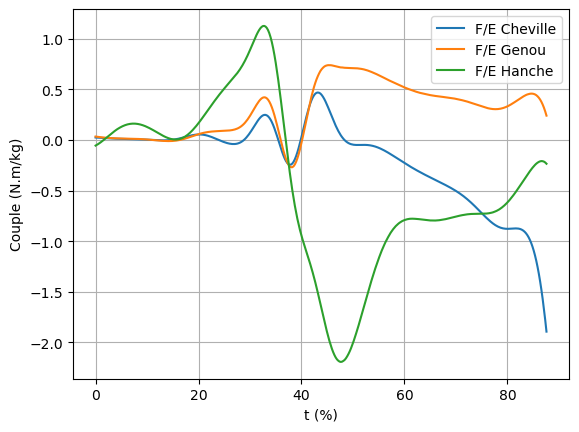

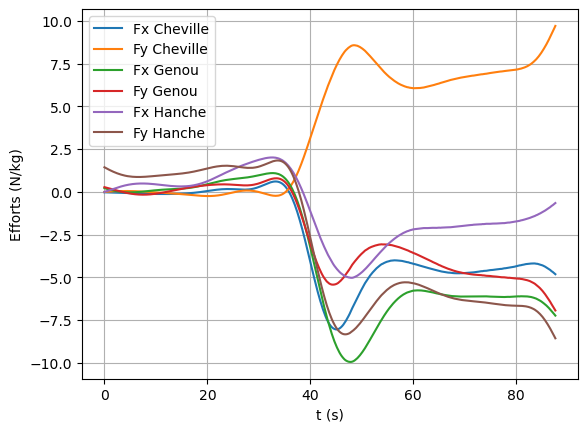

In [11]:
off=624
t1=1275 #right toe off

t2=1629 #double support
t3=1679 #right toe off

t4=1428 # right heel strike
nf_cycle=len(t_point[t1:t3]) #gait cycle length
nf_trace=len(t_point[t1:t2])
t_percent=np.linspace(0., 100, num=nf_cycle) #normalized between 0 and 100%
plt.plot(t_percent[0:nf_trace],Gf[2,t1-off:t2-off]/68)
plt.plot(t_percent[0:nf_trace],Gs[2,t1-off:t2-off]/68)
plt.plot(t_percent[0:nf_trace],Gt[2,t1-off:t2-off]/68)
plt.xlabel('t (%)')
plt.ylabel('Couple (N.m/kg)')
plt.legend(['F/E Cheville','F/E Genou','F/E Hanche'])
plt.grid()
plt.show()


plt.plot(t_percent[0:nf_trace],Ff[0,t1-off:t2-off]/68)
plt.plot(t_percent[0:nf_trace],Ff[1,t1-off:t2-off]/68)
plt.plot(t_percent[0:nf_trace],Fs[0,t1-off:t2-off]/68)
plt.plot(t_percent[0:nf_trace],Fs[1,t1-off:t2-off]/68)
plt.plot(t_percent[0:nf_trace],Ft[0,t1-off:t2-off]/68)
plt.plot(t_percent[0:nf_trace],Ft[1,t1-off:t2-off]/68)
plt.xlabel('t (s)')
plt.ylabel('Efforts (N/kg)')
plt.legend(['Fx Cheville','Fy Cheville','Fx Genou','Fy Genou','Fx Hanche','Fy Hanche'])
plt.grid()
plt.show()